In [ ]:
!pip install wandb
!wandb login

In [6]:
%env WANDB_LOG_MODEL=true

env: WANDB_LOG_MODEL=true


In [2]:
!pip install datasets transformers
!pip install transformers[torch]
!pip install accelerate[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-

## Load dataset

In [3]:
from datasets import load_dataset

ds = load_dataset('xyfang/indoor_rooms')
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2138 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/265 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/273 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2138
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 265
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 273
    })
})

In [4]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['bathroom', 'bedroom', 'dining_room', 'garage', 'kitchen', 'livingroom'], id=None)

Filter:   0%|          | 0/2138 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2138 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2138 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2138 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2138 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2138 [00:00<?, ? examples/s]

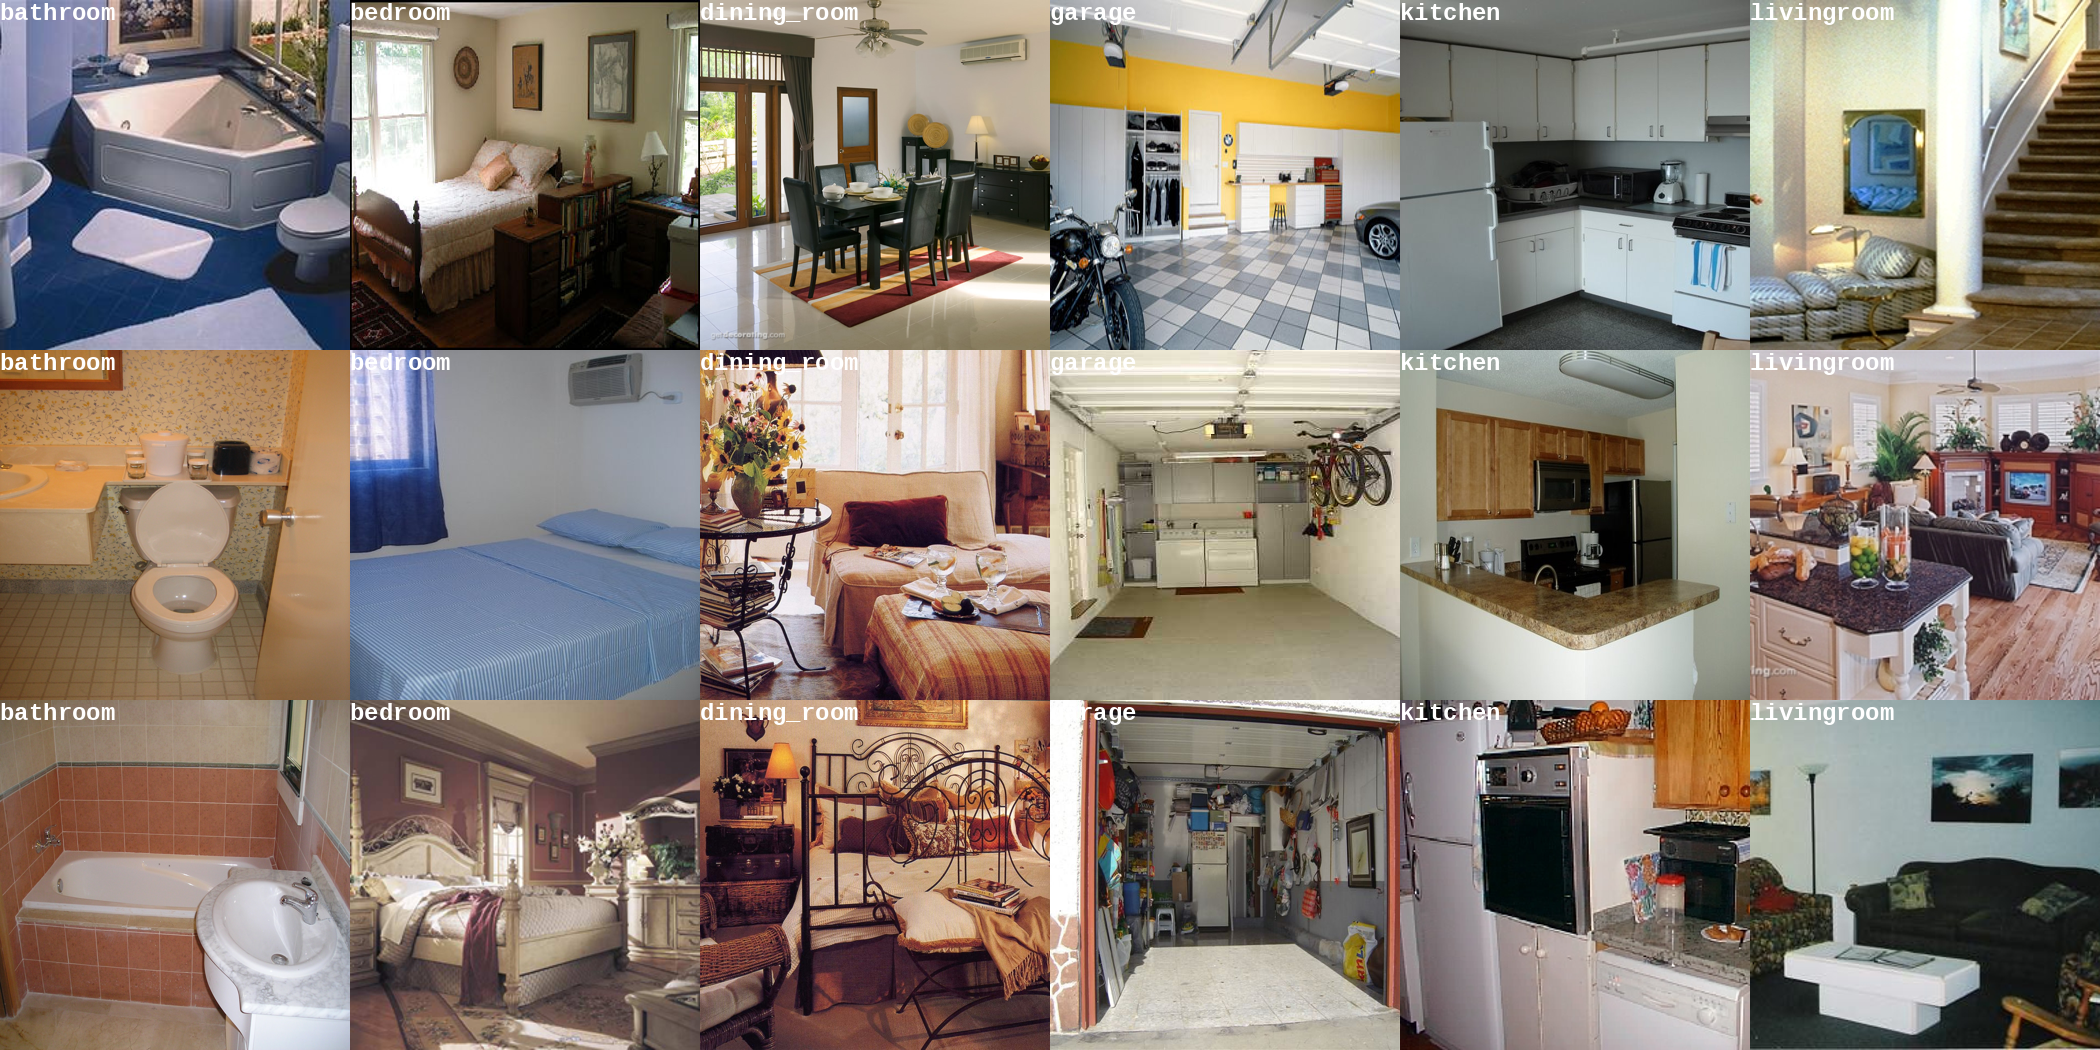

In [5]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(len(labels) * h, examples_per_class * w))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx // examples_per_class * h, idx % examples_per_class * w)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

## Loading ViT Feature Extractor

In [10]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [11]:
feature_extractor

ViTFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

## Processing the Dataset

In [12]:
ds = load_dataset('xyfang/indoor_rooms')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert('RGB') for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs

prepared_ds = ds.with_transform(transform)

In [13]:
prepared_ds['train'][0]


{'pixel_values': tensor([[[-0.4275, -0.4275, -0.4118,  ...,  0.9765,  0.9529,  0.9137],
          [-0.4196, -0.4275, -0.4039,  ...,  0.9765,  0.9608,  0.9451],
          [-0.4196, -0.4275, -0.4039,  ...,  0.9843,  0.9843,  0.9686],
          ...,
          [-0.5922, -0.6078, -0.5922,  ...,  0.2627,  0.2627,  0.2471],
          [-0.6078, -0.6078, -0.6000,  ...,  0.2314,  0.2549,  0.2471],
          [-0.6157, -0.6157, -0.6000,  ...,  0.2235,  0.2157,  0.2392]],
 
         [[-0.5373, -0.5373, -0.5216,  ...,  0.9843,  0.9686,  0.9451],
          [-0.5294, -0.5373, -0.5137,  ...,  0.9843,  0.9843,  0.9686],
          [-0.5294, -0.5373, -0.5137,  ...,  0.9843,  0.9922,  0.9843],
          ...,
          [-0.6941, -0.7098, -0.6941,  ...,  0.2078,  0.1922,  0.1765],
          [-0.7098, -0.7098, -0.7020,  ...,  0.1765,  0.1843,  0.1765],
          [-0.7176, -0.7176, -0.7020,  ...,  0.1686,  0.1451,  0.1686]],
 
         [[-0.6314, -0.6314, -0.6078,  ...,  0.9373,  0.8353,  0.7647],
          [-

# Training and Evaluation

### Data Collator

In [14]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

### Evaluation Metric

In [15]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-15-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [16]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from transformers import TrainingArguments
import wandb

training_args = TrainingArguments(
  report_to = 'wandb',
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  # report_to='tensorboard',
  load_best_model_at_end=True,
  run_name = 'vit_running'
)

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [19]:
train_results = trainer.train()

wandb: Currently logged in as: liuxia62 (jennisleepin). Use `wandb login --relogin` to force relogin


In [20]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 617220302GF
  train_loss               =       0.258
  train_runtime            =  0:04:13.77
  train_samples_per_second =      33.699
  train_steps_per_second   =       2.112


In [21]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.8981
  eval_loss               =     0.3869
  eval_runtime            = 0:00:08.39
  eval_samples_per_second =     31.581
  eval_steps_per_second   =      4.052


In [24]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("test", metrics)
wandb.summary['test_accuracy'] = metrics['eval_accuracy']
trainer.save_metrics("test", metrics)

***** test metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.8425
  eval_loss               =     0.5359
  eval_runtime            = 0:00:07.23
  eval_samples_per_second =     37.715
  eval_steps_per_second   =      4.835


In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'xyfang/indoor_rooms',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

In [ ]:
wandb.finish()